Book 3

In [3]:
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_vm/bin/python3.6


In [4]:
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial
import tensorflow as tf

print("Python version used = ", sys.version)
print("Numpy version = ", np.__version__)
print("Tensorflow version = ", tf.__version__)

Python version used =  3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Numpy version =  1.18.5
Tensorflow version =  2.3.1


In [5]:
config = {
    "IMAGE_SIZE" : (512, 512),
    "AUTOTUNE" : tf.data.experimental.AUTOTUNE,
    "BATCH_SIZE" : 16
}

In [6]:
training_filenames = tf.io.gfile.glob("tfrec_binary_classification/train*.tfrec")
validation_filenames = tf.io.gfile.glob("tfrec_binary_classification/val*.tfrec")
testing_filenames = tf.io.gfile.glob("tfrec_binary_classification/test*.tfrec")

print("Number of training TFRec files = ", len(training_filenames))
print("Number of validation TFRec files = ", len(validation_filenames))
print("Number of testing TFRec files = ", len(testing_filenames))

Number of training TFRec files =  94
Number of validation TFRec files =  21
Number of testing TFRec files =  21


# Define The Loading Pipeline : 

* Call **load_dataset** function : This function is called with validation/training/testing filenames. In case the dataset is unlabeled, simply pass False parameter to it, along with a choice whether you want to load things in order or not. Normally, **we disable it for boosting our computation speed**. This load_training dataset will return our dataset(a pair of **(image, label) if labeled = True** was passed, otherwise **(image, image_name))**. How it does that, will be seen ahead in the notebook.
* Now, we have images wih us, in the dataset. We will define and call image_augmentation method to apply some transformation to these images, before we use them further.
* Once it is done, we call the repeat function which repeats this dataset so each original value is seen count times. The default behavior (if count is None or -1) is for the dataset be repeated indefinitely.
* Shuffling - The shuffle( ) function randomly shuffles the elements of this dataset.Internally, the dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required. *For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer*.
* Group the images into batches.
* **Prefetch( )** : Most dataset input pipelines should end with a call to prefetch. **This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements**.
* **cache( )** : The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data. When caching to a file, the cached data will persist across runs. Even the first iteration through the data will read from the cache file.

In [7]:
def get_training_dataset() : 
    dataset = load_dataset(training_filenames, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls = config["AUTOTUNE"])
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config["BATCH_SIZE"])
    dataset = dataset.prefetch(config["AUTOTUNE"])
    return dataset

In [8]:
def get_validation_dataset() :
    dataset = load_dataset(validation_filenames, labeled = True, ordered = True)
    dataset = dataset.batch(config["BATCH_SIZE"])
    dataset = dataset.cache()
    dataset = dataset.prefetch(config["AUTOTUNE"])
    return dataset

In [9]:
def get_testing_dataset() : 
    dataset = load_dataset(testing_filenames, labeled = True, ordered = True)
    dataset = dataset.batch(config["BATCH_SIZE"])
    dataset = dataset.cache()
    dataset = dataset.prefetch(config["AUTOTUNE"])
    return dataset

# Structuring Functions :
These functions will help in overall structuring of the pipeline.

Setting default value of :

* **ordered as False** - For high performance we will be reading data from multiple file sources at once, and the dataset will be shuffled before reading commences.

* **labeled as true** - Can set it to False too, doesn't matter much. Or, simply leave it be.

*Role of partial( ) functools :*

Treat this as an operation which results in a object(called partial object). **These objects when invoked, behave like functions with positional/additional(but not mandatory) arguments**.

So, sometimes we may have labels, hence the function call will be initated using labeled = True. Sometimes, we won't. In that case, function calls will be initiated with a False initialization of the labeled argument.

In [10]:
def load_dataset(filenames, labeled = True, ordered = False):
    ignore_order = tf.data.Options()
    if ordered == False : 
        ignore_order.experimental_deterministic = False # disable order
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = config["AUTOTUNE"])
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(partial(read_tfrecord, labeled = labeled), num_parallel_calls = config["AUTOTUNE"])
    return dataset

According to feature mapping present in our TFRecord files, we design the following functions.

In [11]:
def read_tfrecord(example, labeled) : 
    if labeled == True : 
        tfrecord_format = {
            "image" : tf.io.FixedLenFeature([], tf.string),
            "label" : tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        tfrecord_format = {
            "image" : tf.io.FixedLenFeature([], tf.string),
            "image_name" : tf.io.FixedLenFeature([], tf.string)
        }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    
    if labeled == True : 
        label = tf.cast(example["label"], tf.int32)
        return image, label
    else:
        image_name = example["image_name"]
        return image, image_name

In [12]:
def decode_image(image) : 
    image = tf.image.decode_jpeg(image, channels = 3) # decode JPEG-encoded image to uint8 tensor
    image = tf.cast(image, tf.float32) 
    image = image/255.0 
    image = tf.reshape(image, [config["IMAGE_SIZE"][0], config["IMAGE_SIZE"][1], 3]) # reshapes tensor structure
    return image

In [13]:
def image_augmentation(image, label) : 
    image = tf.image.resize(image, [config["IMAGE_SIZE"][0], config["IMAGE_SIZE"][1]])
    image = tf.image.random_flip_left_right(image)
    return image, label

In [14]:
def batch_to_numpy(batch_data) : 
    images, labels = batch_data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object : 
        numpy_labels = [None for _ in enumerate(numpy_images)] # image_name is there. Not label.
    return numpy_images, numpy_labels

In [15]:
label_dict = {
    0 : "Healthy",
    1 : "Nodular"
}

def display_batch(batch_data, predictions = None) : 
    images, labels = batch_to_numpy(batch_data)
    if all(labels == None) : 
        labels = [None for _ in enumerate(images)]
    
    rows = int(math.sqrt(len(images)))
    columns = len(images)//rows
    
    plt.figure(figsize = (20, 20))
    for n in range(len(images)) : 
        ax = plt.subplot(rows, columns, n + 1)
        plt.imshow(images[n])
        if labels[n] is not None : 
            plt.title(label_dict[labels[n]], fontsize = 16)
    plt.grid(False)
    plt.tight_layout()

# Get Datasets

In [16]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()
testing_dataset = get_testing_dataset()

print("Training dataset |||| ", training_dataset)
print("Validation dataset |||| ", validation_dataset)
print("Testing dataset |||| ", testing_dataset)

Training dataset ||||  <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation dataset ||||  <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Testing dataset ||||  <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>


In [17]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(training_filenames)
num_validation_images = count_data_items(validation_filenames)
num_testing_images = count_data_items(testing_filenames)

STEPS_PER_EPOCH_TRAIN = num_training_images // config["BATCH_SIZE"]
STEPS_PER_EPOCH_VAL = num_validation_images // config["BATCH_SIZE"]

print("Number of Training Images = ", num_training_images)
print("Number of validation Images = ", num_validation_images)
print("Number of Testing Images = ", num_testing_images)
print("\n")
print("Numer of steps per epoch in Train = ", STEPS_PER_EPOCH_TRAIN)
print("Numer of steps per epoch in Validation = ", STEPS_PER_EPOCH_VAL)

Number of Training Images =  466840
Number of validation Images =  100040
Number of Testing Images =  100040


Numer of steps per epoch in Train =  29177
Numer of steps per epoch in Validation =  6252


In [18]:
training_iter = iter(training_dataset.unbatch().batch(16))
print(training_iter)

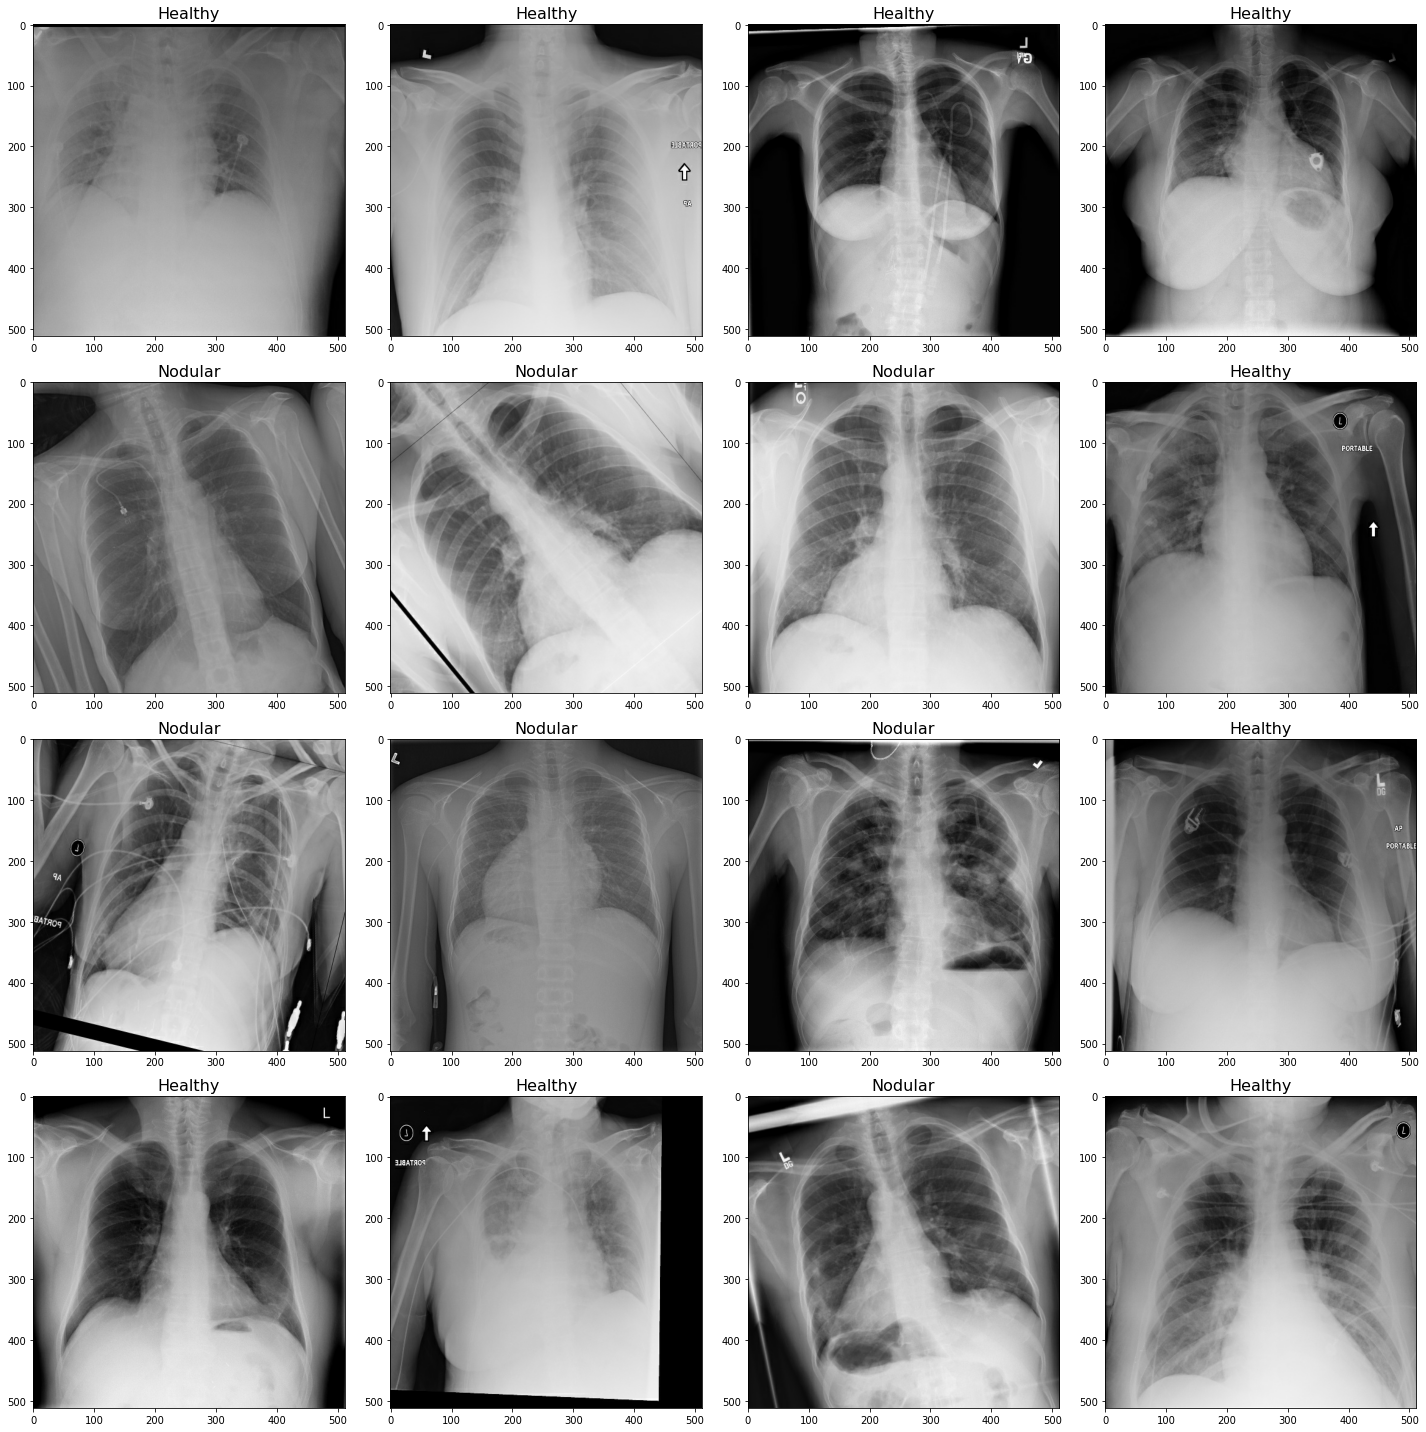

In [19]:
display_batch(next(training_iter))

In [20]:
del training_iter

# Model Construction : 

In [21]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision available")

Mixed precision available


Setting up Tensorboard's Log Root Directory.

In [29]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir() : 
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

## Callbacks

In [30]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(patience = 8, verbose = 1, restore_best_weights = True)
callback_lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_auc", factor = 0.1, patience = 3, verbose = 1, min_lr = 1e-5)
callback_tensorboard = tf.keras.callbacks.TensorBoard(run_logdir)

In [41]:
def build_model(input_shape) : 
    input_tensor = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
    
    base_model = tf.keras.applications.VGG16(include_top = False, weights = "imagenet", input_tensor = input_tensor, pooling = "avg")
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 256, activation = "relu"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 256, activation = "relu"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 128, activation = "relu"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 128, activation = "relu"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 60, activation = "relu"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 30, activation = "relu"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 10, activation = "relu"),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(units = 1, activation = "sigmoid")
        
    ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-1), loss = tf.keras.losses.BinaryCrossentropy(), 
                  metrics = [tf.keras.metrics.AUC(name = "auc")])
    return model

In [43]:
input_shape = (config["IMAGE_SIZE"][0], config["IMAGE_SIZE"][1], 3)
with tf.device("/device:GPU:0"):
    model = build_model(input_shape)
    print(model.summary())
    print("\nInput Analysis = ", model.input)
    print("\nOutput Analysis = ", model.output)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)              

In [39]:
def model_layer_analysis(model) : 
    pd.set_option("max_colwidth", None)
    info = [(layer.name, layer.trainable, layer) for layer in model.layers]
    analysis = pd.DataFrame(info, columns = ["Layer Name", "Train Status", "Layer Type"])
    print(analysis

(512, 512, 3)